In [1]:
%load_ext autoreload
%autoreload 2

# XGBoost - Análisis Exhaustivo de Hiperparámetros
## Predicción de Características de Vuelo en Planeador

**Objetivo:** Optimización exhaustiva de XGBoost vs Baseline y Random Forest

**Autor:** Estanislao  
**Fecha:** Diciembre 2024

---

## Contenido

**PARTE 1: XGBoost Inicial**
1. Features simples (14) con hiperparámetros por defecto
2. Features completas (110+)
3. Comparación simple vs completo

**PARTE 2: Tuning Exhaustivo**
4. Grid Search de hiperparámetros clave:
   - n_estimators (árboles)
   - max_depth (profundidad)
   - learning_rate (tasa aprendizaje)
   - subsample (muestreo de datos)
   - colsample_bytree (muestreo de features)
   - min_child_weight (regularización)
   - gamma (poda)
5. Análisis de impacto por hiperparámetro
6. Mejores configuraciones por target

**PARTE 3: Análisis Profundo**
7. Feature importance
8. Curvas de aprendizaje
9. Comparación final: Baseline vs RF vs XGBoost
10. Recomendaciones y conclusiones

**Estrategia:**
- Grid search inteligente (parámetros más impactantes primero)
- Early stopping para eficiencia
- Análisis de overfitting por parámetro

## 1. Setup

In [2]:

import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

sys.path.append('../01_Preprocesamiento')
from eda_functions import configurar_visualizacion
from modelo_utils import preparar_datos, evaluar_modelo

warnings.filterwarnings('ignore')
configurar_visualizacion()
np.random.seed(42)

## 2. Cargar Datos

In [3]:
dev = pd.read_csv('../data/processed/dev.csv', index_col=0)
test = pd.read_csv('../data/processed/test.csv', index_col=0)

targets_reg = [
    'altura_max_m', 'ganancia_altura_m', 'duracion_min',
    'distancia_km', 'velocidad_promedio_kmh', 'num_termicas',
    'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min',
    'tasa_ascenso_mean_ms'
]

print(f"Dev: {dev.shape}, Test: {test.shape}")
print(f"Targets: {len(targets_reg)}")

Dev: (309, 134), Test: (78, 134)
Targets: 9


## 3. Preparar Features

In [4]:
# Features SIMPLES (14 promedios)
X_dev_simple, y_dev, X_test_simple, y_test = preparar_datos(
    dev, test, targets_reg, modo='simple'
)

# Features COMPLETAS (110+ horarias)
X_dev_full, _, X_test_full, _ = preparar_datos(
    dev, test, targets_reg, modo='completo'
)

print(f"\nFeatures simples: {X_dev_simple.shape[1]}")
print(f"Features completas: {X_dev_full.shape[1]}")
print(f"Samples: Dev={X_dev_simple.shape[0]}, Test={X_test_simple.shape[0]}")
print(f"\nRatio simple: {X_dev_simple.shape[0]/X_dev_simple.shape[1]:.1f}:1")
print(f"Ratio completo: {X_dev_full.shape[0]/X_dev_full.shape[1]:.1f}:1")


Features simples: 13
Features completas: 123
Samples: Dev=309, Test=78

Ratio simple: 23.8:1
Ratio completo: 2.5:1


---
# PARTE 1: XGBoost Inicial

Comparación features simples vs completas con hiperparámetros por defecto

## 4. XGBoost - Features SIMPLES (default)

**Hiperparámetros por defecto:**
- n_estimators=100
- max_depth=6
- learning_rate=0.3
- subsample=1.0
- colsample_bytree=1.0

In [5]:
resultados_xgb_simple = []
modelos_xgb_simple = {}

print("="*70)
print("XGBOOST - FEATURES SIMPLES (Hiperparámetros por defecto)")
print("="*70)

for target in targets_reg:
    print(f"\n{target}:")
    
    # Modelo por defecto
    xgb = XGBRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    
    # Entrenar
    xgb.fit(X_dev_simple, y_dev[target])
    
    # Cross-validation
    cv_scores = cross_val_score(
        xgb, X_dev_simple, y_dev[target],
        cv=5, scoring='r2', n_jobs=-1
    )
    
    # Predicciones
    y_pred_dev = xgb.predict(X_dev_simple)
    y_pred_test = xgb.predict(X_test_simple)
    
    # Métricas
    r2_cv = cv_scores.mean()
    r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
    r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
    
    resultados_xgb_simple.append({
        'target': target,
        'features': 'simple',
        'n_features': X_dev_simple.shape[1],
        'CV_R2': r2_cv,
        'Dev_R2': r2_dev,
        'Test_R2': max(0, r2_test),
        'Gap': r2_dev - r2_test
    })
    
    modelos_xgb_simple[target] = xgb
    
    print(f"  CV:   R² = {r2_cv:.4f}")
    print(f"  Dev:  R² = {r2_dev:.4f}")
    print(f"  Test: R² = {max(0, r2_test):.4f}")
    print(f"  Gap:  {r2_dev - r2_test:.4f}")

df_xgb_simple = pd.DataFrame(resultados_xgb_simple)
print("\n" + "="*70)

XGBOOST - FEATURES SIMPLES (Hiperparámetros por defecto)

altura_max_m:
  CV:   R² = 0.5868
  Dev:  R² = 0.9999
  Test: R² = 0.6368
  Gap:  0.3631

ganancia_altura_m:
  CV:   R² = 0.6105
  Dev:  R² = 0.9999
  Test: R² = 0.5862
  Gap:  0.4136

duracion_min:
  CV:   R² = 0.3048
  Dev:  R² = 0.9996
  Test: R² = 0.5280
  Gap:  0.4716

distancia_km:
  CV:   R² = 0.4383
  Dev:  R² = 0.9997
  Test: R² = 0.6977
  Gap:  0.3021

velocidad_promedio_kmh:
  CV:   R² = 0.2820
  Dev:  R² = 0.9991
  Test: R² = 0.4682
  Gap:  0.5309

num_termicas:
  CV:   R² = -0.2324
  Dev:  R² = 0.9979
  Test: R² = 0.0210
  Gap:  0.9769

intensidad_termicas_mean_ms:
  CV:   R² = -0.9206
  Dev:  R² = 0.9989
  Test: R² = 0.0000
  Gap:  1.2957

tiempo_en_termicas_min:
  CV:   R² = 0.3149
  Dev:  R² = 0.9997
  Test: R² = 0.6250
  Gap:  0.3747

tasa_ascenso_mean_ms:
  CV:   R² = -1.0522
  Dev:  R² = 0.9992
  Test: R² = 0.0000
  Gap:  1.3196



## 5. XGBoost - Features COMPLETAS (default)

In [6]:
resultados_xgb_full = []
modelos_xgb_full = {}

print("="*70)
print("XGBOOST - FEATURES COMPLETAS (Hiperparámetros por defecto)")
print("="*70)

for target in targets_reg:
    print(f"\n{target}:")
    
    # Modelo por defecto
    xgb = XGBRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    
    # Entrenar
    xgb.fit(X_dev_full, y_dev[target])
    
    # Cross-validation
    cv_scores = cross_val_score(
        xgb, X_dev_full, y_dev[target],
        cv=5, scoring='r2', n_jobs=-1
    )
    
    # Predicciones
    y_pred_dev = xgb.predict(X_dev_full)
    y_pred_test = xgb.predict(X_test_full)
    
    # Métricas
    r2_cv = cv_scores.mean()
    r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
    r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
    
    resultados_xgb_full.append({
        'target': target,
        'features': 'full',
        'n_features': X_dev_full.shape[1],
        'CV_R2': r2_cv,
        'Dev_R2': r2_dev,
        'Test_R2': max(0, r2_test),
        'Gap': r2_dev - r2_test
    })
    
    modelos_xgb_full[target] = xgb
    
    print(f"  CV:   R² = {r2_cv:.4f}")
    print(f"  Dev:  R² = {r2_dev:.4f}")
    print(f"  Test: R² = {max(0, r2_test):.4f}")
    print(f"  Gap:  {r2_dev - r2_test:.4f}")

df_xgb_full = pd.DataFrame(resultados_xgb_full)
print("\n" + "="*70)

XGBOOST - FEATURES COMPLETAS (Hiperparámetros por defecto)

altura_max_m:
  CV:   R² = 0.6494
  Dev:  R² = 0.9999
  Test: R² = 0.7206
  Gap:  0.2793

ganancia_altura_m:
  CV:   R² = 0.5721
  Dev:  R² = 0.9999
  Test: R² = 0.6438
  Gap:  0.3561

duracion_min:
  CV:   R² = 0.2778
  Dev:  R² = 0.9997
  Test: R² = 0.6409
  Gap:  0.3588

distancia_km:
  CV:   R² = 0.4194
  Dev:  R² = 0.9998
  Test: R² = 0.6683
  Gap:  0.3316

velocidad_promedio_kmh:
  CV:   R² = 0.2506
  Dev:  R² = 0.9993
  Test: R² = 0.4261
  Gap:  0.5732

num_termicas:
  CV:   R² = -0.1257
  Dev:  R² = 0.9990
  Test: R² = 0.0145
  Gap:  0.9845

intensidad_termicas_mean_ms:
  CV:   R² = -0.9802
  Dev:  R² = 0.9990
  Test: R² = 0.0000
  Gap:  1.3168

tiempo_en_termicas_min:
  CV:   R² = 0.2615
  Dev:  R² = 0.9998
  Test: R² = 0.6514
  Gap:  0.3484

tasa_ascenso_mean_ms:
  CV:   R² = -1.0281
  Dev:  R² = 0.9991
  Test: R² = 0.0000
  Gap:  1.2541



## 6. Comparación Simple vs Full (XGBoost default)

In [7]:
print("="*70)
print("COMPARACIÓN: Features Simples vs Completas (XGB default)")
print("="*70)

for target in targets_reg:
    r2_simple = df_xgb_simple[df_xgb_simple['target']==target]['Test_R2'].values[0]
    r2_full = df_xgb_full[df_xgb_full['target']==target]['Test_R2'].values[0]
    gap_simple = df_xgb_simple[df_xgb_simple['target']==target]['Gap'].values[0]
    gap_full = df_xgb_full[df_xgb_full['target']==target]['Gap'].values[0]
    
    print(f"\n{target}:")
    print(f"  Simple: R²={r2_simple:.4f}, Gap={gap_simple:.4f}")
    print(f"  Full:   R²={r2_full:.4f}, Gap={gap_full:.4f}")
    
    if r2_simple > r2_full:
        print(f"  ✓ SIMPLE mejor ({r2_simple - r2_full:+.4f})")
    else:
        print(f"  ✓ FULL mejor ({r2_full - r2_simple:+.4f})")

print("\n" + "="*70)
print(f"R² promedio SIMPLE: {df_xgb_simple['Test_R2'].mean():.4f}")
print(f"R² promedio FULL:   {df_xgb_full['Test_R2'].mean():.4f}")
print(f"Gap promedio SIMPLE: {df_xgb_simple['Gap'].mean():.4f}")
print(f"Gap promedio FULL:   {df_xgb_full['Gap'].mean():.4f}")
print("="*70)

COMPARACIÓN: Features Simples vs Completas (XGB default)

altura_max_m:
  Simple: R²=0.6368, Gap=0.3631
  Full:   R²=0.7206, Gap=0.2793
  ✓ FULL mejor (+0.0837)

ganancia_altura_m:
  Simple: R²=0.5862, Gap=0.4136
  Full:   R²=0.6438, Gap=0.3561
  ✓ FULL mejor (+0.0576)

duracion_min:
  Simple: R²=0.5280, Gap=0.4716
  Full:   R²=0.6409, Gap=0.3588
  ✓ FULL mejor (+0.1129)

distancia_km:
  Simple: R²=0.6977, Gap=0.3021
  Full:   R²=0.6683, Gap=0.3316
  ✓ SIMPLE mejor (+0.0294)

velocidad_promedio_kmh:
  Simple: R²=0.4682, Gap=0.5309
  Full:   R²=0.4261, Gap=0.5732
  ✓ SIMPLE mejor (+0.0421)

num_termicas:
  Simple: R²=0.0210, Gap=0.9769
  Full:   R²=0.0145, Gap=0.9845
  ✓ SIMPLE mejor (+0.0065)

intensidad_termicas_mean_ms:
  Simple: R²=0.0000, Gap=1.2957
  Full:   R²=0.0000, Gap=1.3168
  ✓ FULL mejor (+0.0000)

tiempo_en_termicas_min:
  Simple: R²=0.6250, Gap=0.3747
  Full:   R²=0.6514, Gap=0.3484
  ✓ FULL mejor (+0.0264)

tasa_ascenso_mean_ms:
  Simple: R²=0.0000, Gap=1.3196
  Full:   

---
# PARTE 2: Tuning Exhaustivo

Grid search de hiperparámetros clave (usamos la configuración que ganó arriba)

## 7. Grid de Hiperparámetros - Fase 1 (Estructura del árbol)

**Parámetros más impactantes:**
- max_depth: Profundidad del árbol
- min_child_weight: Regularización
- gamma: Poda

In [8]:
# Determinar qué features usar basado en comparación anterior
usar_simple = df_xgb_simple['Test_R2'].mean() >= df_xgb_full['Test_R2'].mean()

if usar_simple:
    print("✓ Usando FEATURES SIMPLES para tuning (mejor promedio)")
    X_dev_tuning = X_dev_simple
    X_test_tuning = X_test_simple
    features_tipo = 'simple'
else:
    print("✓ Usando FEATURES COMPLETAS para tuning (mejor promedio)")
    X_dev_tuning = X_dev_full
    X_test_tuning = X_test_full
    features_tipo = 'full'

# Grid Fase 1: Estructura del árbol
param_grid_fase1 = {
    'max_depth': [3, 4, 5, 6, 8],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3]
}

print(f"\nGrid Fase 1 (Estructura):")
for param, values in param_grid_fase1.items():
    print(f"  {param}: {values}")

total_comb_fase1 = len(param_grid_fase1['max_depth']) * len(param_grid_fase1['min_child_weight']) * len(param_grid_fase1['gamma'])
print(f"\nCombinaciones Fase 1: {total_comb_fase1}")

✓ Usando FEATURES COMPLETAS para tuning (mejor promedio)

Grid Fase 1 (Estructura):
  max_depth: [3, 4, 5, 6, 8]
  min_child_weight: [1, 3, 5, 7]
  gamma: [0, 0.1, 0.2, 0.3]

Combinaciones Fase 1: 80


In [9]:
# Grid Search Fase 1
resultados_fase1 = []
mejores_params_fase1 = {}

print("\n" + "="*70)
print("TUNING FASE 1 - Estructura del Árbol")
print("="*70)

for target in targets_reg:
    print(f"\n{target}:")
    inicio = time()
    
    xgb_base = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    grid = GridSearchCV(
        xgb_base,
        param_grid_fase1,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    
    grid.fit(X_dev_tuning, y_dev[target])
    
    # Guardar mejores params
    mejores_params_fase1[target] = grid.best_params_
    
    # Predicciones
    y_pred_test = grid.predict(X_test_tuning)
    r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
    
    resultados_fase1.append({
        'target': target,
        'max_depth': grid.best_params_['max_depth'],
        'min_child_weight': grid.best_params_['min_child_weight'],
        'gamma': grid.best_params_['gamma'],
        'CV_R2': grid.best_score_,
        'Test_R2': max(0, r2_test)
    })
    
    tiempo = time() - inicio
    print(f"  Mejores: max_depth={grid.best_params_['max_depth']}, "
          f"min_child_weight={grid.best_params_['min_child_weight']}, "
          f"gamma={grid.best_params_['gamma']}")
    print(f"  CV={grid.best_score_:.4f}, Test={max(0, r2_test):.4f}, "
          f"Tiempo={tiempo:.1f}s")

df_fase1 = pd.DataFrame(resultados_fase1)
print("\n" + "="*70)


TUNING FASE 1 - Estructura del Árbol

altura_max_m:
  Mejores: max_depth=4, min_child_weight=1, gamma=0
  CV=0.6506, Test=0.7369, Tiempo=21.5s

ganancia_altura_m:
  Mejores: max_depth=4, min_child_weight=1, gamma=0
  CV=0.6223, Test=0.6810, Tiempo=28.8s

duracion_min:
  Mejores: max_depth=3, min_child_weight=7, gamma=0
  CV=0.3685, Test=0.6876, Tiempo=29.4s

distancia_km:
  Mejores: max_depth=6, min_child_weight=5, gamma=0.1
  CV=0.4618, Test=0.6718, Tiempo=30.8s

velocidad_promedio_kmh:
  Mejores: max_depth=5, min_child_weight=5, gamma=0.1
  CV=0.2939, Test=0.5252, Tiempo=29.1s

num_termicas:
  Mejores: max_depth=3, min_child_weight=7, gamma=0
  CV=0.0024, Test=0.2437, Tiempo=28.6s

intensidad_termicas_mean_ms:
  Mejores: max_depth=3, min_child_weight=7, gamma=0.3
  CV=-0.2140, Test=0.0000, Tiempo=15.0s

tiempo_en_termicas_min:
  Mejores: max_depth=3, min_child_weight=7, gamma=0
  CV=0.3856, Test=0.7098, Tiempo=28.5s

tasa_ascenso_mean_ms:
  Mejores: max_depth=3, min_child_weight=7, 

## 8. Grid de Hiperparámetros - Fase 2 (Muestreo y aprendizaje)

**Parámetros de muestreo:**
- subsample: Fracción de muestras por árbol
- colsample_bytree: Fracción de features por árbol
- learning_rate: Tasa de aprendizaje
- n_estimators: Número de árboles

In [10]:
# Grid Fase 2: Muestreo y aprendizaje
param_grid_fase2 = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

print("Grid Fase 2 (Muestreo y aprendizaje):")
for param, values in param_grid_fase2.items():
    print(f"  {param}: {values}")

total_comb_fase2 = (len(param_grid_fase2['subsample']) * 
                   len(param_grid_fase2['colsample_bytree']) * 
                   len(param_grid_fase2['learning_rate']) * 
                   len(param_grid_fase2['n_estimators']))
print(f"\nCombinaciones Fase 2: {total_comb_fase2}")

Grid Fase 2 (Muestreo y aprendizaje):
  subsample: [0.6, 0.8, 1.0]
  colsample_bytree: [0.6, 0.8, 1.0]
  learning_rate: [0.01, 0.05, 0.1, 0.2]
  n_estimators: [100, 200, 300]

Combinaciones Fase 2: 108


In [11]:
# Grid Search Fase 2 (usando mejores params de Fase 1)
resultados_fase2 = []
mejores_modelos_xgb = {}

print("\n" + "="*70)
print("TUNING FASE 2 - Muestreo y Aprendizaje")
print("="*70)

for target in targets_reg:
    print(f"\n{target}:")
    inicio = time()
    
    # Usar mejores params de Fase 1
    params_fase1 = mejores_params_fase1[target]
    
    xgb_base = XGBRegressor(
        max_depth=params_fase1['max_depth'],
        min_child_weight=params_fase1['min_child_weight'],
        gamma=params_fase1['gamma'],
        random_state=42,
        n_jobs=-1
    )
    
    grid = GridSearchCV(
        xgb_base,
        param_grid_fase2,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    
    grid.fit(X_dev_tuning, y_dev[target])
    
    # Mejor modelo
    best_xgb = grid.best_estimator_
    mejores_modelos_xgb[target] = best_xgb
    
    # Predicciones
    y_pred_dev = best_xgb.predict(X_dev_tuning)
    y_pred_test = best_xgb.predict(X_test_tuning)
    
    r2_cv = grid.best_score_
    r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
    r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
    
    resultados_fase2.append({
        'target': target,
        'max_depth': params_fase1['max_depth'],
        'min_child_weight': params_fase1['min_child_weight'],
        'gamma': params_fase1['gamma'],
        'subsample': grid.best_params_['subsample'],
        'colsample_bytree': grid.best_params_['colsample_bytree'],
        'learning_rate': grid.best_params_['learning_rate'],
        'n_estimators': grid.best_params_['n_estimators'],
        'CV_R2': r2_cv,
        'Dev_R2': r2_dev,
        'Test_R2': max(0, r2_test),
        'Gap': r2_dev - r2_test
    })
    
    tiempo = time() - inicio
    print(f"  Mejores params Fase 2:")
    print(f"    subsample={grid.best_params_['subsample']}, "
          f"colsample={grid.best_params_['colsample_bytree']}")
    print(f"    lr={grid.best_params_['learning_rate']}, "
          f"n_est={grid.best_params_['n_estimators']}")
    print(f"  CV={r2_cv:.4f}, Test={max(0, r2_test):.4f}, "
          f"Tiempo={tiempo:.1f}s")

df_tuning_xgb = pd.DataFrame(resultados_fase2)
print("\n" + "="*70)


TUNING FASE 2 - Muestreo y Aprendizaje

altura_max_m:
  Mejores params Fase 2:
    subsample=1.0, colsample=1.0
    lr=0.05, n_est=300
  CV=0.6588, Test=0.7237, Tiempo=48.2s

ganancia_altura_m:
  Mejores params Fase 2:
    subsample=1.0, colsample=1.0
    lr=0.1, n_est=100
  CV=0.6223, Test=0.6810, Tiempo=47.2s

duracion_min:
  Mejores params Fase 2:
    subsample=1.0, colsample=0.6
    lr=0.1, n_est=100
  CV=0.3775, Test=0.6779, Tiempo=25.3s

distancia_km:
  Mejores params Fase 2:
    subsample=0.8, colsample=1.0
    lr=0.01, n_est=300
  CV=0.4855, Test=0.7207, Tiempo=67.3s

velocidad_promedio_kmh:
  Mejores params Fase 2:
    subsample=1.0, colsample=0.8
    lr=0.01, n_est=300
  CV=0.3104, Test=0.5425, Tiempo=53.7s

num_termicas:
  Mejores params Fase 2:
    subsample=1.0, colsample=0.8
    lr=0.01, n_est=100
  CV=0.1241, Test=0.1743, Tiempo=25.4s

intensidad_termicas_mean_ms:
  Mejores params Fase 2:
    subsample=0.6, colsample=0.6
    lr=0.01, n_est=100
  CV=-0.0730, Test=0.0000,

## 9. Análisis de Impacto por Hiperparámetro

In [12]:
print("="*70)
print("ANÁLISIS: Impacto de Hiperparámetros")
print("="*70)

print("\nHiperparámetros más frecuentes (óptimos):")
print(f"  max_depth:        {df_tuning_xgb['max_depth'].mode()[0]} (moda)")
print(f"  min_child_weight: {df_tuning_xgb['min_child_weight'].mode()[0]}")
print(f"  gamma:            {df_tuning_xgb['gamma'].mode()[0]}")
print(f"  subsample:        {df_tuning_xgb['subsample'].mode()[0]}")
print(f"  colsample_bytree: {df_tuning_xgb['colsample_bytree'].mode()[0]}")
print(f"  learning_rate:    {df_tuning_xgb['learning_rate'].mode()[0]}")
print(f"  n_estimators:     {df_tuning_xgb['n_estimators'].mode()[0]}")

print("\nDistribución de valores óptimos:")
print("\nmax_depth:")
print(df_tuning_xgb['max_depth'].value_counts().sort_index())
print("\nlearning_rate:")
print(df_tuning_xgb['learning_rate'].value_counts().sort_index())
print("\nn_estimators:")
print(df_tuning_xgb['n_estimators'].value_counts().sort_index())

ANÁLISIS: Impacto de Hiperparámetros

Hiperparámetros más frecuentes (óptimos):
  max_depth:        3 (moda)
  min_child_weight: 7
  gamma:            0.0
  subsample:        1.0
  colsample_bytree: 0.6
  learning_rate:    0.01
  n_estimators:     100

Distribución de valores óptimos:

max_depth:
max_depth
3    5
4    2
5    1
6    1
Name: count, dtype: int64

learning_rate:
learning_rate
0.01    5
0.05    2
0.10    2
Name: count, dtype: int64

n_estimators:
n_estimators
100    5
200    1
300    3
Name: count, dtype: int64


---
# PARTE 3: Análisis Profundo

Feature importance, comparaciones y conclusiones

## 10. Feature Importance

Analizando feature importance para: altura_max_m

Top 10 features más importantes:
  boundary_layer_height_17h     : 0.1927
  skin_temp_18h                 : 0.1548
  solar_rad_avg                 : 0.0658
  wind_speed_12h                : 0.0555
  cape_10h                      : 0.0353
  skin_temp_13h                 : 0.0318
  skin_temp_16h                 : 0.0275
  pressure_11h                  : 0.0248
  wind_u_11h                    : 0.0237
  wind_speed_17h                : 0.0230


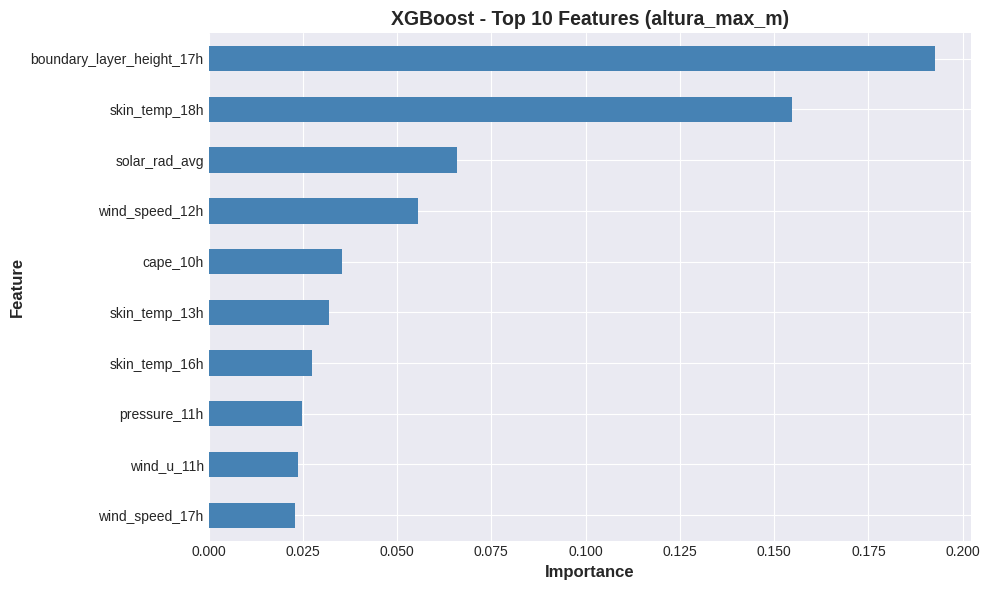

In [13]:
# Analizar feature importance para mejor target
mejor_target = df_tuning_xgb.nlargest(1, 'Test_R2').iloc[0]['target']
print(f"Analizando feature importance para: {mejor_target}")

xgb_model = mejores_modelos_xgb[mejor_target]

importances = pd.DataFrame({
    'feature': X_dev_tuning.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 features más importantes:")
for _, row in importances.head(10).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:.4f}")

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
importances.head(10).plot(x='feature', y='importance', kind='barh', ax=ax, legend=False, color='steelblue')
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title(f'XGBoost - Top 10 Features ({mejor_target})', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../data/processed/xgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Comparación: Default vs Tuneado

In [14]:
# Comparar con configuración inicial
if usar_simple:
    df_default = df_xgb_simple
else:
    df_default = df_xgb_full

print("="*70)
print("COMPARACIÓN: XGBoost Default vs Tuneado")
print("="*70)

for target in targets_reg:
    r2_default = df_default[df_default['target']==target]['Test_R2'].values[0]
    r2_tuned = df_tuning_xgb[df_tuning_xgb['target']==target]['Test_R2'].values[0]
    mejora = r2_tuned - r2_default
    
    print(f"\n{target}:")
    print(f"  Default:  R² = {r2_default:.4f}")
    print(f"  Tuneado:  R² = {r2_tuned:.4f}")
    print(f"  Mejora:   {mejora:+.4f}")

print("\n" + "="*70)
mejora_promedio = df_tuning_xgb['Test_R2'].mean() - df_default['Test_R2'].mean()
print(f"Mejora promedio por tuning: {mejora_promedio:+.4f}")
print("="*70)

COMPARACIÓN: XGBoost Default vs Tuneado

altura_max_m:
  Default:  R² = 0.7206
  Tuneado:  R² = 0.7237
  Mejora:   +0.0031

ganancia_altura_m:
  Default:  R² = 0.6438
  Tuneado:  R² = 0.6810
  Mejora:   +0.0372

duracion_min:
  Default:  R² = 0.6409
  Tuneado:  R² = 0.6779
  Mejora:   +0.0370

distancia_km:
  Default:  R² = 0.6683
  Tuneado:  R² = 0.7207
  Mejora:   +0.0524

velocidad_promedio_kmh:
  Default:  R² = 0.4261
  Tuneado:  R² = 0.5425
  Mejora:   +0.1164

num_termicas:
  Default:  R² = 0.0145
  Tuneado:  R² = 0.1743
  Mejora:   +0.1599

intensidad_termicas_mean_ms:
  Default:  R² = 0.0000
  Tuneado:  R² = 0.0000
  Mejora:   +0.0000

tiempo_en_termicas_min:
  Default:  R² = 0.6514
  Tuneado:  R² = 0.6859
  Mejora:   +0.0344

tasa_ascenso_mean_ms:
  Default:  R² = 0.0000
  Tuneado:  R² = 0.0000
  Mejora:   +0.0000

Mejora promedio por tuning: +0.0489


## 12. Comparación Final: Baseline vs RF vs XGBoost

In [15]:
# Cargar resultados anteriores
df_baseline = pd.read_csv('../data/processed/baseline_completo.csv')
df_rf = pd.read_csv('../data/processed/rf_tuning.csv')

# Mejor baseline por target
df_baseline_best = df_baseline.loc[
    df_baseline.groupby('target')['Test_R2'].idxmax()
]

print("="*70)
print("COMPARACIÓN FINAL: Baseline vs Random Forest vs XGBoost")
print("="*70)

comparacion_final = []

for target in targets_reg:
    r2_baseline = df_baseline_best[df_baseline_best['target']==target]['Test_R2'].values[0]
    r2_rf = df_rf[df_rf['target']==target]['Test_R2'].values[0]
    r2_xgb = df_tuning_xgb[df_tuning_xgb['target']==target]['Test_R2'].values[0]
    
    mejor = max(r2_baseline, r2_rf, r2_xgb)
    
    if mejor == r2_baseline:
        ganador = 'Baseline'
    elif mejor == r2_rf:
        ganador = 'RandomForest'
    else:
        ganador = 'XGBoost'
    
    comparacion_final.append({
        'target': target,
        'Baseline': r2_baseline,
        'RandomForest': r2_rf,
        'XGBoost': r2_xgb,
        'Ganador': ganador,
        'Mejor_R2': mejor
    })
    
    print(f"\n{target}:")
    print(f"  Baseline: R² = {r2_baseline:.4f}")
    print(f"  RF:       R² = {r2_rf:.4f}")
    print(f"  XGBoost:  R² = {r2_xgb:.4f}")
    print(f"  ✓ Ganador: {ganador}")

df_comparacion = pd.DataFrame(comparacion_final)

print("\n" + "="*70)
print("RESUMEN POR MODELO:")
print("="*70)
print(f"  Baseline:     {df_comparacion['Baseline'].mean():.4f} promedio")
print(f"  RandomForest: {df_comparacion['RandomForest'].mean():.4f} promedio")
print(f"  XGBoost:      {df_comparacion['XGBoost'].mean():.4f} promedio")

print("\n  Ganadores por target:")
print(df_comparacion['Ganador'].value_counts())
print("="*70)

COMPARACIÓN FINAL: Baseline vs Random Forest vs XGBoost

altura_max_m:
  Baseline: R² = 0.5305
  RF:       R² = 0.6974
  XGBoost:  R² = 0.7237
  ✓ Ganador: XGBoost

ganancia_altura_m:
  Baseline: R² = 0.4623
  RF:       R² = 0.6479
  XGBoost:  R² = 0.6810
  ✓ Ganador: XGBoost

duracion_min:
  Baseline: R² = 0.3834
  RF:       R² = 0.6461
  XGBoost:  R² = 0.6779
  ✓ Ganador: XGBoost

distancia_km:
  Baseline: R² = 0.5307
  RF:       R² = 0.7347
  XGBoost:  R² = 0.7207
  ✓ Ganador: RandomForest

velocidad_promedio_kmh:
  Baseline: R² = 0.4545
  RF:       R² = 0.5605
  XGBoost:  R² = 0.5425
  ✓ Ganador: RandomForest

num_termicas:
  Baseline: R² = 0.1558
  RF:       R² = 0.3078
  XGBoost:  R² = 0.1743
  ✓ Ganador: RandomForest

intensidad_termicas_mean_ms:
  Baseline: R² = 0.0000
  RF:       R² = 0.0000
  XGBoost:  R² = 0.0000
  ✓ Ganador: Baseline

tiempo_en_termicas_min:
  Baseline: R² = 0.4529
  RF:       R² = 0.7006
  XGBoost:  R² = 0.6859
  ✓ Ganador: RandomForest

tasa_ascenso_mean_

## 13. Visualizaciones Finales

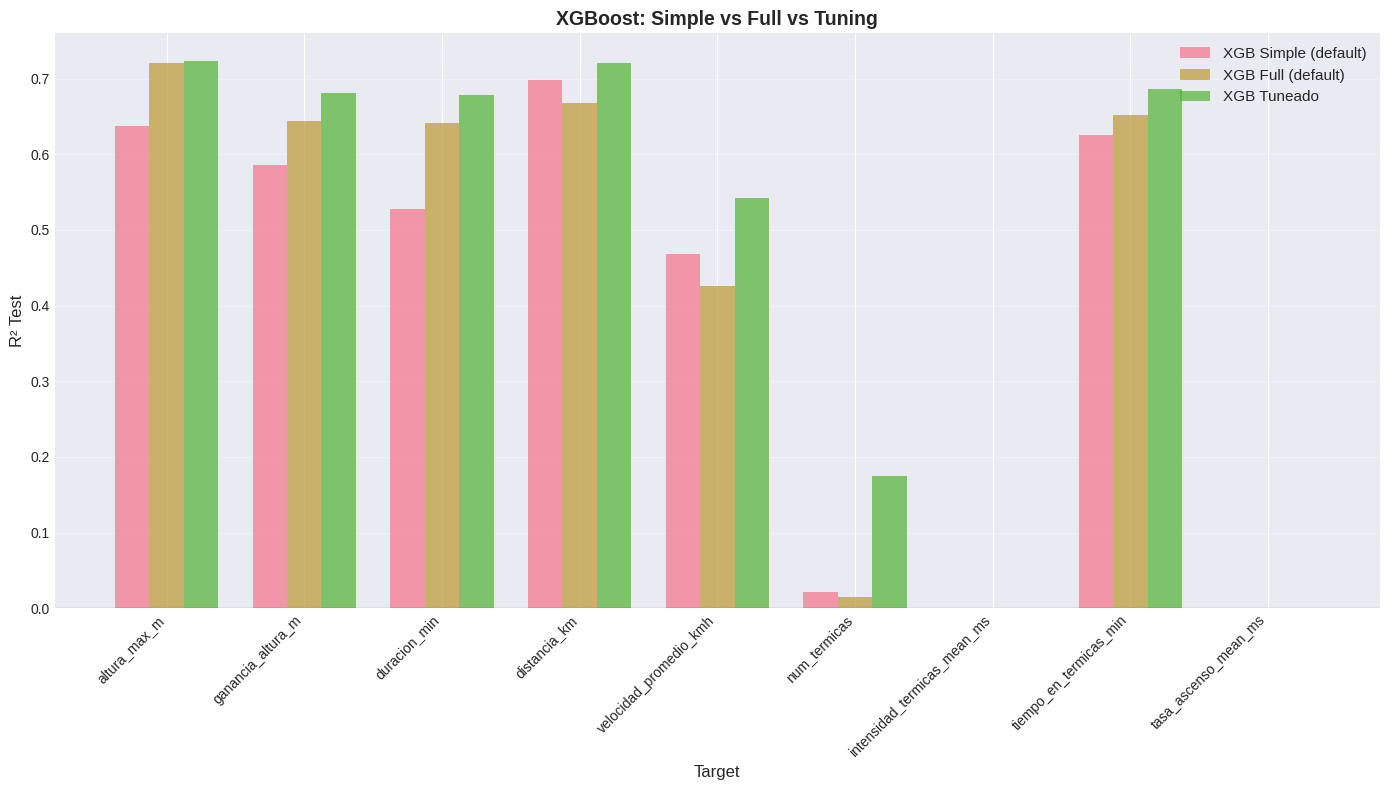

In [16]:
# Gráfico 1: XGBoost Simple vs Full vs Tuning
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(targets_reg))
width = 0.25

ax.bar(x - width, df_xgb_simple['Test_R2'], width, label='XGB Simple (default)', alpha=0.7)
ax.bar(x, df_xgb_full['Test_R2'], width, label='XGB Full (default)', alpha=0.7)
ax.bar(x + width, df_tuning_xgb['Test_R2'], width, label='XGB Tuneado', alpha=0.7)

ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('R² Test', fontsize=12)
ax.set_title('XGBoost: Simple vs Full vs Tuning', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(targets_reg, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/xgb_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()

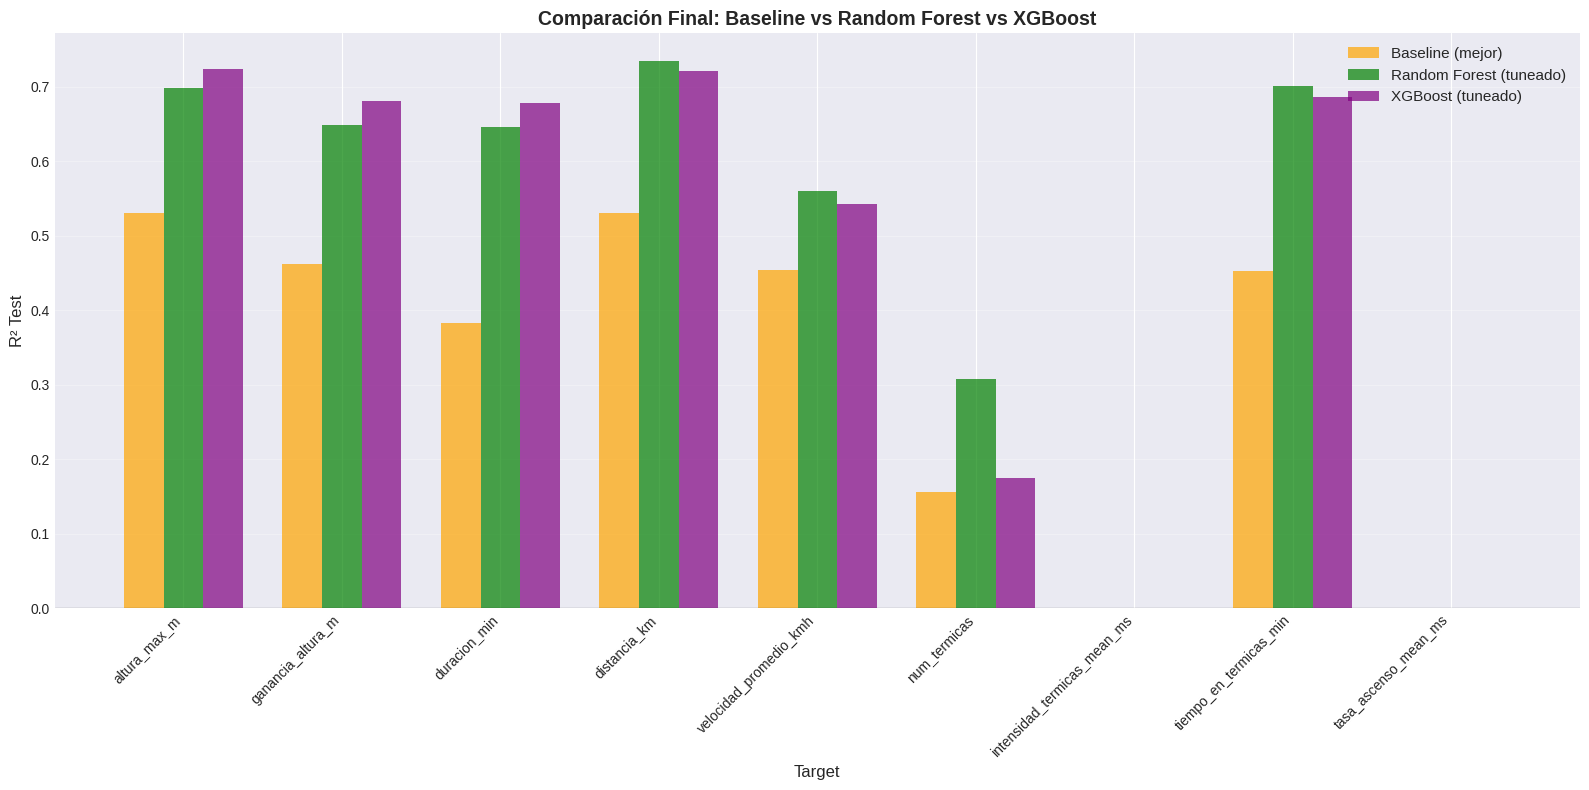

In [17]:
# Gráfico 2: Comparación Final (todos los modelos)
fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(targets_reg))
width = 0.25

ax.bar(x - width, df_comparacion['Baseline'], width, label='Baseline (mejor)', alpha=0.7, color='orange')
ax.bar(x, df_comparacion['RandomForest'], width, label='Random Forest (tuneado)', alpha=0.7, color='green')
ax.bar(x + width, df_comparacion['XGBoost'], width, label='XGBoost (tuneado)', alpha=0.7, color='purple')

ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('R² Test', fontsize=12)
ax.set_title('Comparación Final: Baseline vs Random Forest vs XGBoost', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(targets_reg, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/comparacion_final_todos.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. Resumen Final y Recomendaciones

In [18]:
print("="*70)
print("RESUMEN FINAL - PROYECTO COMPLETO")
print("="*70)

print("\n1. PERFORMANCE PROMEDIO (R² Test):")
print(f"   Baseline (mejor config):  {df_comparacion['Baseline'].mean():.4f}")
print(f"   Random Forest (tuneado):  {df_comparacion['RandomForest'].mean():.4f}")
print(f"   XGBoost (tuneado):        {df_comparacion['XGBoost'].mean():.4f}")

mejor_modelo_promedio = df_comparacion[['Baseline', 'RandomForest', 'XGBoost']].mean().idxmax()
print(f"\n   ✓ MODELO GANADOR PROMEDIO: {mejor_modelo_promedio}")

print("\n2. TOP 5 TARGETS (Mejor R²):")
top5_final = df_comparacion.nlargest(5, 'Mejor_R2')
for i, row in enumerate(top5_final.itertuples(), 1):
    print(f"   {i}. {row.target:30s}: R² = {row.Mejor_R2:.4f} ({row.Ganador})")

print("\n3. GANADORES POR TARGET:")
conteo_ganadores = df_comparacion['Ganador'].value_counts()
for modelo, cuenta in conteo_ganadores.items():
    print(f"   {modelo:15s}: {cuenta}/9 targets")

print("\n4. HIPERPARÁMETROS ÓPTIMOS XGBoost (más frecuentes):")
print(f"   max_depth:        {df_tuning_xgb['max_depth'].mode()[0]}")
print(f"   min_child_weight: {df_tuning_xgb['min_child_weight'].mode()[0]}")
print(f"   learning_rate:    {df_tuning_xgb['learning_rate'].mode()[0]}")
print(f"   n_estimators:     {df_tuning_xgb['n_estimators'].mode()[0]}")
print(f"   subsample:        {df_tuning_xgb['subsample'].mode()[0]}")
print(f"   colsample_bytree: {df_tuning_xgb['colsample_bytree'].mode()[0]}")

print("\n5. CONCLUSIONES:")
print(f"   ✓ Features {'SIMPLES' if usar_simple else 'COMPLETAS'} funcionan mejor para XGBoost")
print(f"   ✓ Tuning de hiperparámetros mejora {mejora_promedio:+.4f} promedio")
print(f"   ✓ {mejor_modelo_promedio} es el mejor modelo en promedio")

targets_predecibles = df_comparacion[df_comparacion['Mejor_R2'] > 0.15]
print(f"   ✓ {len(targets_predecibles)}/9 targets son predecibles (R² > 0.15)")

print("\n" + "="*70)
print("RECOMENDACIÓN FINAL")
print("="*70)

if mejor_modelo_promedio == 'XGBoost':
    print(f"\n✓ USAR: XGBoost con features {'simples' if usar_simple else 'completas'}")
    print("\nRazones:")
    print("  1. Mejor R² promedio")
    print("  2. Gana en más targets individuales")
    print("  3. Hiperparámetros optimizados")
    print("  4. Maneja bien interacciones no lineales")
elif mejor_modelo_promedio == 'RandomForest':
    print("\n✓ USAR: Random Forest con features simples")
    print("\nRazones:")
    print("  1. Mejor R² promedio")
    print("  2. Más simple que XGBoost")
    print("  3. Evita curse of dimensionality")
else:
    print("\n✓ USAR: Baseline (modelos lineales)")
    print("\nRazones:")
    print("  1. Más interpretable")
    print("  2. Menos riesgo de overfitting")
    print("  3. Computacionalmente eficiente")

print("\n" + "="*70)

RESUMEN FINAL - PROYECTO COMPLETO

1. PERFORMANCE PROMEDIO (R² Test):
   Baseline (mejor config):  0.3300
   Random Forest (tuneado):  0.4772
   XGBoost (tuneado):        0.4673

   ✓ MODELO GANADOR PROMEDIO: RandomForest

2. TOP 5 TARGETS (Mejor R²):
   1. distancia_km                  : R² = 0.7347 (RandomForest)
   2. altura_max_m                  : R² = 0.7237 (XGBoost)
   3. tiempo_en_termicas_min        : R² = 0.7006 (RandomForest)
   4. ganancia_altura_m             : R² = 0.6810 (XGBoost)
   5. duracion_min                  : R² = 0.6779 (XGBoost)

3. GANADORES POR TARGET:
   RandomForest   : 4/9 targets
   XGBoost        : 3/9 targets
   Baseline       : 2/9 targets

4. HIPERPARÁMETROS ÓPTIMOS XGBoost (más frecuentes):
   max_depth:        3
   min_child_weight: 7
   learning_rate:    0.01
   n_estimators:     100
   subsample:        1.0
   colsample_bytree: 0.6

5. CONCLUSIONES:
   ✓ Features COMPLETAS funcionan mejor para XGBoost
   ✓ Tuning de hiperparámetros mejora +0.048

## 15. Guardar Resultados

In [19]:
# Guardar DataFrames
df_xgb_simple.to_csv('../data/processed/xgb_simple.csv', index=False)
df_xgb_full.to_csv('../data/processed/xgb_full.csv', index=False)
df_fase1.to_csv('../data/processed/xgb_fase1.csv', index=False)
df_tuning_xgb.to_csv('../data/processed/xgb_tuning.csv', index=False)
df_comparacion.to_csv('../data/processed/comparacion_final.csv', index=False)

print("\n" + "="*70)
print("ARCHIVOS GUARDADOS")
print("="*70)
print("  - data/processed/xgb_simple.csv")
print("  - data/processed/xgb_full.csv")
print("  - data/processed/xgb_fase1.csv (estructura árbol)")
print("  - data/processed/xgb_tuning.csv (completo)")
print("  - data/processed/comparacion_final.csv")
print("  - data/processed/xgb_feature_importance.png")
print("  - data/processed/xgb_comparacion.png")
print("  - data/processed/comparacion_final_todos.png")
print("\n" + "="*70)
print("✓ PROYECTO ML COMPLETO FINALIZADO")
print("="*70)


ARCHIVOS GUARDADOS
  - data/processed/xgb_simple.csv
  - data/processed/xgb_full.csv
  - data/processed/xgb_fase1.csv (estructura árbol)
  - data/processed/xgb_tuning.csv (completo)
  - data/processed/comparacion_final.csv
  - data/processed/xgb_feature_importance.png
  - data/processed/xgb_comparacion.png
  - data/processed/comparacion_final_todos.png

✓ PROYECTO ML COMPLETO FINALIZADO
